# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

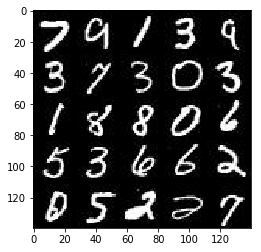

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

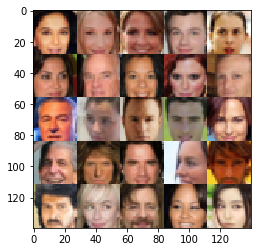

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following tuple (tensor of real input images, tensor of z data, learning rate)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    # Implement Function
    
    input_images = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels])
    z_data = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)

    return input_images, z_data, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 (MNIST) or 28x28x3 (CelebA)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.75):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    g_dropout_training = is_train # Can fix to true, if advantageous, for noise during inference/generation
    g_dropout_seed = 31
    # Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=keep_prob, seed=g_dropout_seed, training=g_dropout_training)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=keep_prob, seed=g_dropout_seed, training=g_dropout_training)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=keep_prob, seed=g_dropout_seed, training=g_dropout_training)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now

        out = tf.tanh(logits)
        
    return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1, keep_prob=0.75):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha, keep_prob=keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    # Applies instance noise: about 16% of the samples will be flipped
    def instance_noise(shape, real=True, stddev=0.1):
        if real:
            return tf.round(tf.truncated_normal(shape, 0.5+stddev, stddev=stddev))
        else:
            return tf.round(tf.truncated_normal(shape, 0.5-stddev, stddev=stddev))
            
#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
#                                                 labels=tf.truncated_normal(tf.shape(d_model_real), 1.0, stddev=smooth)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
#                                                 labels=tf.abs(tf.truncated_normal(tf.shape(d_model_fake), 0.0, stddev=smooth))))

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=instance_noise(tf.shape(d_model_real))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=instance_noise(tf.shape(d_model_fake), real=False)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # 1. Display and model parameters
    print_every = 10
    show_every = 100
    n_images = 25
    
    smooth = 0.3
    keep_prob = 0.5
    alpha = 0.25
    
    # 2. Build Model
    tf.reset_default_graph()
        
    # NOTE: Data shape is (samples, width, height, channels)
    input_images, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, z_data, data_shape[3], alpha=alpha, smooth=smooth, keep_prob=keep_prob)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    # 3. Train model
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                # TODO: Train Model
                steps += 1
                    
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Rescale images to [-1, 1]
                batch_images = batch_images * 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, 
                                               z_data: batch_z,
                                               learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, 
                                                z_data: batch_z,
                                               learn_rate: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_images: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({input_images: batch_images, z_data: batch_z})
                    train_loss_g = g_loss.eval({input_images: batch_images, z_data: batch_z}) # train a second time

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_data, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 4.1180
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 2.0141
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.4108
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 1.7138
Epoch 1/2... Discriminator Loss: 1.5619... Generator Loss: 3.3922
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 1.5695... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 3.8351
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 1.7449
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.2424


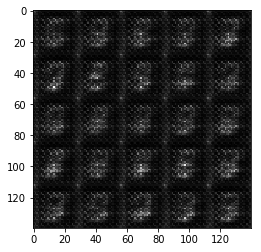

Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 1.4966
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.1339
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.1921... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 0.8475
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 1.8896
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 1.4765
Epoch 1/2... Discriminator Loss: 1.7097... Generator Loss: 3.0556
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 2.0719


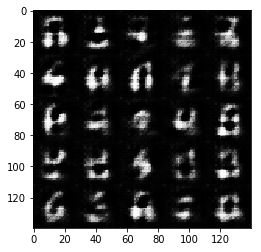

Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 1.2078
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 1.6224
Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 1.8558
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.8633
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.8199
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 2.0946


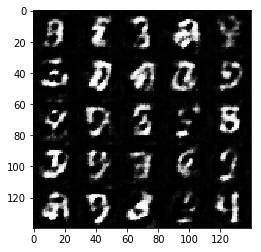

Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 2.0018
Epoch 1/2... Discriminator Loss: 1.1433... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 1.9717
Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.2775
Epoch 1/2... Discriminator Loss: 1.0274... Generator Loss: 1.1705
Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 1.4260
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 1.0989... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 1.2182


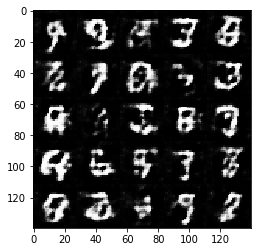

Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.5969
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 1.6283
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.9747
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.9953
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.3994
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 1.7517
Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 2.0805
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 1.7937


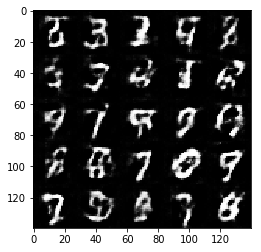

Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 1.2274
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 0.9812... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 1.2786
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.6236
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.6949


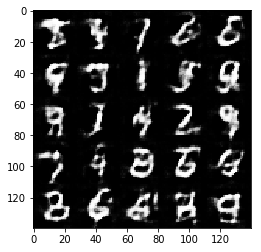

Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 2.2973
Epoch 2/2... Discriminator Loss: 0.9800... Generator Loss: 1.4705
Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 2.0626
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.2136
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 1.2802
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 1.0601
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 2.3518
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 1.5635


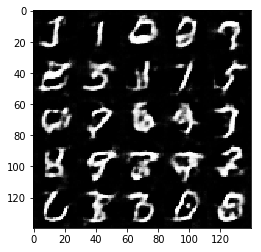

Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 1.1837... Generator Loss: 1.8729
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.4152
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 1.4914
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 1.5314
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 1.2187
Epoch 2/2... Discriminator Loss: 1.0068... Generator Loss: 1.6869
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 1.4795
Epoch 2/2... Discriminator Loss: 0.9455... Generator Loss: 1.3357


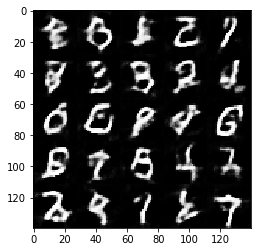

Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 1.0361
Epoch 2/2... Discriminator Loss: 1.0502... Generator Loss: 1.4399
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 1.7390
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.2953
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 1.1097... Generator Loss: 1.1994
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.2539
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 1.0913
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.2773


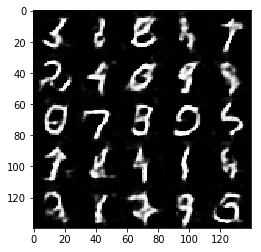

Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 1.8442
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 1.9502
Epoch 2/2... Discriminator Loss: 1.1980... Generator Loss: 0.7168


IndexError: list index out of range

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 2.9625
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 2.2178
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 6.0250
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 2.2801
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 5.5814
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 5.1221
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 4.0598
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.6061


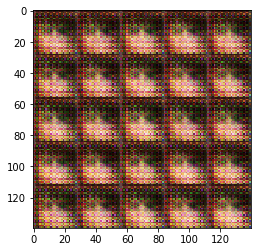

Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 3.8741
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 2.2488
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 2.6652
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.7833
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 2.2812
Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 2.6065
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 1.7995
Epoch 1/1... Discriminator Loss: 0.9357... Generator Loss: 1.4863


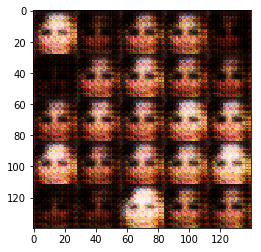

Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 2.2462
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.8129
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.7963
Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.7069
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 2.1316


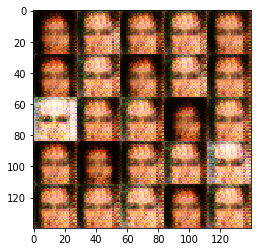

Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.8560
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 2.3215
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 2.8743
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.7235
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 2.4006
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.4991
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 2.2599
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.8848
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.7751


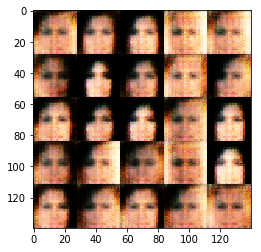

Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 2.1468
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.7658
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.3358
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.8864
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 2.1368
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 2.5889
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 2.8425


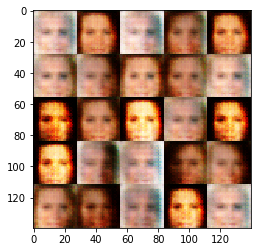

Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 2.1498
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 3.6231
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.5042


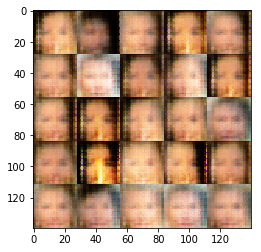

Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 2.0535
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.8550
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.5675
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 2.0316
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 2.1562
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 3.0910
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.4592


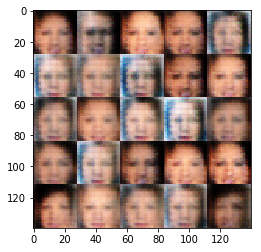

Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.8342
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.5634
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 1.1093
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 2.3845
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.7945
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8188


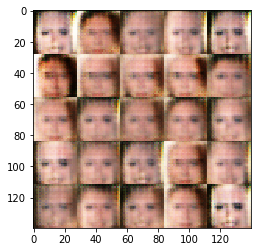

Epoch 1/1... Discriminator Loss: 0.9112... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 2.2236
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.7038
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.8106
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.4486


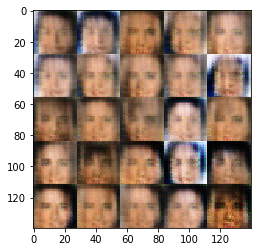

Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 2.0001
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 1.0731
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 1.6406


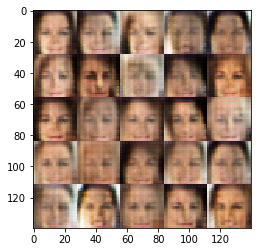

Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 2.1388
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.6037
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.6778


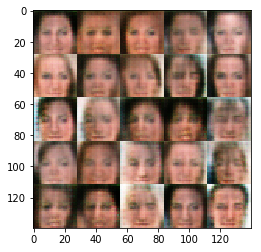

Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 1.9155
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.8280
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.9819
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.4123


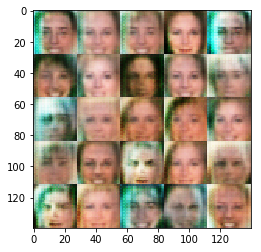

Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.3393
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 1.8310
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.4510


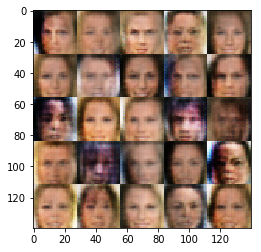

Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.7052
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.8754
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.2047


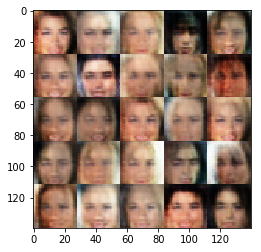

Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.2741
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.3748


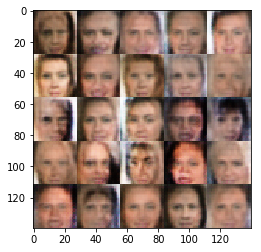

Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.7488
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 2.0137
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.3896
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.2036


IndexError: list index out of range

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Discussion of results

1. Managed to keep the losses close, but not to drop the generator loss consistently under the discriminator loss.
2. Tried several techniques to _cripple_ the discriminator, including:
- one-sided label smoothing
- two-sided label smoothing
- instance noise (used in this model)
- adding dropout to the generator as noise (probably resulting in the blurry faces learned)
3. One of the iterations managed to drop the generator loss consistently under the discriminator loss, but it was a partial run and I could not reproduce it again.
4. The two "list index out of order" appearing at the end of the runs appear to be a _off-by-one_ error that I had no time to reproduce and fix.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.